### Alpaca/Quandl API

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from scipy.optimize import minimize
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [3]:
type(alpaca_secret_key)

str

#### Check Available Tickers from Alpaca Markets API

In [4]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]

In [5]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head())

symbol
0    AXP
1    DEO
2    DSS
3    ICL
4    ARB

In [7]:
# inputs from users
answer = 'N'
while answer == 'N':
# number of stocks
    n = int(input("Enter number of tickers : ")) 
  
    # Below line read inputs from user using map() function  
    tickers = list(map(str,input("\nEnter the ticker names separated by a blank space: ").strip().split()))[:n] 
  
    print("\nList of tickers is - ", tickers)
    answer = str(input('Is this list is not correct type "N"')) 

Enter number of tickers :  3

Enter the ticker names separated by a blank space:  AMZN JNJ TIF



List of tickers is -  ['AMZN', 'JNJ', 'TIF']


Is this list is not correct type "N" y


In [8]:
# Set timeframe to '1D'
timeframe = '1D'

## subtracting time stamps?

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index df
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head(10)

AMZN       JNJ     TIF
                               close     close   close
time                                                  
2019-01-02 00:00:00-05:00  1536.7300  127.6800  81.750
2019-01-03 00:00:00-05:00  1502.0700  126.2140  79.610
2019-01-04 00:00:00-05:00  1574.5400  127.8300  82.340
2019-01-07 00:00:00-05:00  1631.1200  127.1400  85.910
2019-01-08 00:00:00-05:00  1655.8350  129.8500  87.010
2019-01-09 00:00:00-05:00  1657.5900  128.8800  86.540
2019-01-10 00:00:00-05:00  1655.5000  129.7650  85.050
2019-01-11 00:00:00-05:00  1639.6600  129.6400  85.780
2019-01-14 00:00:00-05:00  1619.8767  128.5598  85.320
2019-01-15 00:00:00-05:00  1672.7500  129.2000  84.435

In [9]:
from datetime import datetime
date_format = "%Y-%m-%d"
a = datetime.strptime('2019-01-01', date_format)
b = datetime.strptime('2019-12-31', date_format)

In [10]:
# returns of assets
returns_df = df.pct_change()

In [11]:
# Drop Nulls
returns_df.dropna(inplace = True)

In [12]:
returns_df.head()

AMZN       JNJ       TIF
                              close     close     close
time                                                   
2019-01-03 00:00:00-05:00 -0.022554 -0.011482 -0.026177
2019-01-04 00:00:00-05:00  0.048247  0.012804  0.034292
2019-01-07 00:00:00-05:00  0.035934 -0.005398  0.043357
2019-01-08 00:00:00-05:00  0.015152  0.021315  0.012804
2019-01-09 00:00:00-05:00  0.001060 -0.007470 -0.005402

In [13]:
# the function that we'll optimize is "neg_portfolio_sharpR"
def neg_portfolio_sharpR (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # compute annual s.d.
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    # we'll use a minimization routine
    # so we define the Sharpe_ratio as negative
    return (-stocks_returns_annual/stocks_returns_sd_ann)

In [14]:
-neg_portfolio_sharpR ([1/3,1/3,1/3])

1.7028548254990692

In [15]:
num_assets = 3
# The constraint is that the sum of weights needs to be equal to 1:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bound = (0.0,1.0) # no negative weights (no short-selling)
bounds = tuple(bound for asset in range(num_assets))
# We use the Sequential Least SQuares Programming (SLSQP) Algorithm
result = minimize(neg_portfolio_sharpR, num_assets*[1./num_assets,],
                        method='SLSQP', bounds=bounds, constraints=constraints)

In [16]:
result

     fun: -1.7240834919283425
     jac: array([-0.14161162, -0.14171261, -0.14158021])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.20770973, 0.40847785, 0.38381242])

In [17]:
np.random.seed(42)
num_ports = 10000
all_weights = np.zeros((num_ports, len(tickers)))
# This array contains the returns (lenght num_ports) 
ret_arr = np.zeros(num_ports)
# This array contains the volatilities (lenght num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    w = np.array(np.random.random(len(tickers)))
    # we need to normalize weights so that these add to 1
    w = w/np.sum(w)
    # Save weights
    all_weights[x,:] = w
    
    # For returns we use the same methodology used
    # for previous sections
    stocks_portfolio_df = returns_df.dot(w)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # array with final returns
    ret_arr[x] = stocks_returns_annual

    # Expected volatility
    vol_arr[x] = stocks_portfolio_df.std()*np.sqrt(252)
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [18]:
# We can verify that the maximum in our simulation
# agrees with the maximum using optimization:
print(f'Max Sharpe Ratio: {sharpe_arr.max()}')
print(f'Its location in the array: {sharpe_arr.argmax()}')
print(f'The weights are these: {all_weights[sharpe_arr.argmax()]}')

Max Sharpe Ratio: 1.7240795649313532
Its location in the array: 5562
The weights are these: [0.20936919 0.40677226 0.38385854]


In [19]:
# these two variables kept the return and volatility
# of the maximum Sharpe-ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

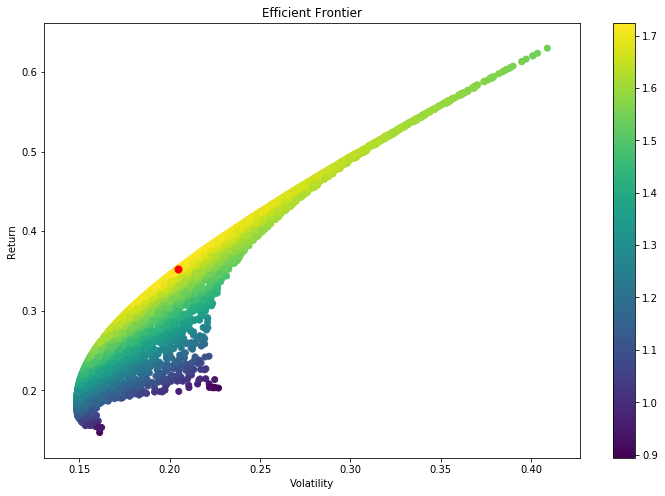

In [20]:
# instructions to plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar()
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
# red dot is the point in the frontier with
# the maximum Sharpe-ratio
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

array([0.19581088, 0.19443847, 0.20411186, ..., 0.19635457, 0.201142  ,
       0.20035191])

In [ ]:
# import plotly.express as px
# fig = px.scatter_3d(x= max_sr_vol, y=max_sr_ret, z='petal_width',
#               color='species')
# fig.show()

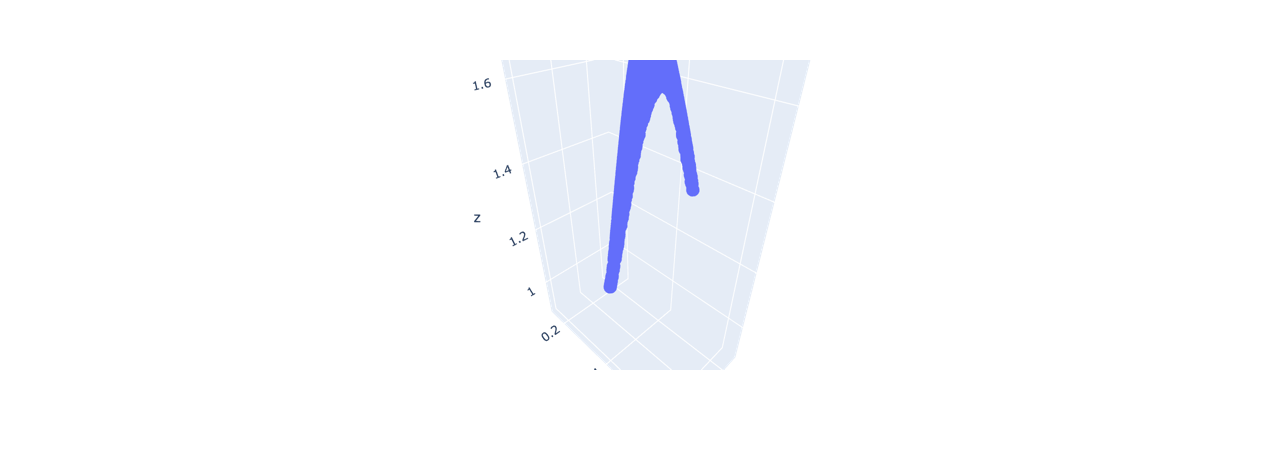

In [35]:
import plotly.express as px
fig = px.scatter_3d(x=vol_arr, y=ret_arr, z=sharpe_arr)
fig.show()

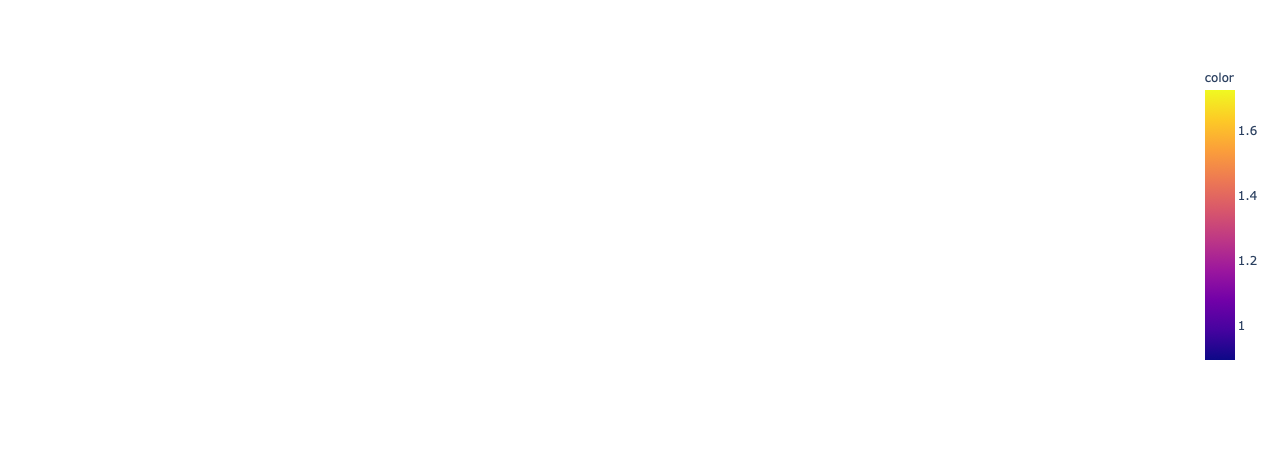

In [38]:
import plotly.express as px
fig = px.scatter_3d(x=vol_arr, y=ret_arr, z=sharpe_arr,
                    color=sharpe_arr)
fig.show()

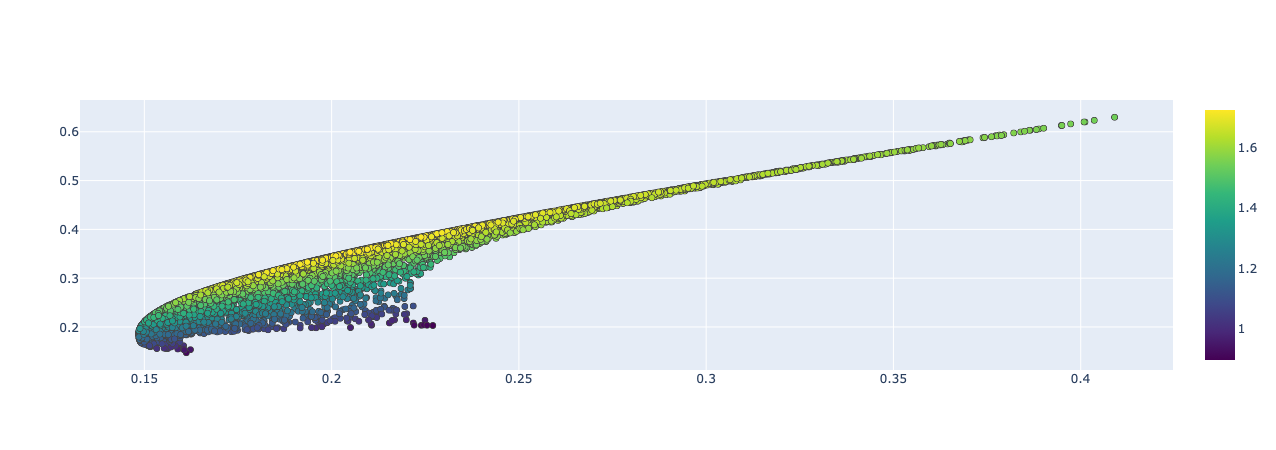

In [49]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = vol_arr,
    y = ret_arr,
    mode='markers',
    marker=dict(
        color=sharpe_arr,
        colorscale='Viridis',
        line_width=1,
        showscale=True
    )
))

fig.show()

# import plotly.graph_objects as go
# import pandas as pd

# data= pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv")

# fig = go.Figure(data=go.Scatter(x=data['Postal'],
#                                 y=data['Population'],
#                                 mode='markers',
#                                 marker_color=data['Population'],
#                                 text=data['State'])) # hover text goes here

# fig.update_layout(title='Population of USA States')
# fig.show()